<h1 style="font-size: 32px; font-weight: bold;">Semantic Segmentation Competition (30%)</h1>

For this competition, we will use a small autonomous driving dataset. The dataset contains 150 training images and 50 testing images.

**We provide baseline code that includes the following features:**

*    Loading the dataset using PyTorch.
*    Defining a simple convolutional neural network for semantic segmentation.
*    How to use existing loss function for the model learning.
*    Train the network on the training data.
*    Test the trained network on the testing data.
<br/><br/>

**The following changes could be considered:**

1. Data augmentation
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, and Drop-out.
3. Architectural changes: Batch Normalization, Residual layers, etc.
4. Use of a new loss function.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.
<br/><br/>


**Marking Rules:**

We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = accuracy mark + efficiency mark + report mark
<br/><br/>


***Accuracy Mark 10:***

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.
<br/><br/>


***Efficiency Mark 10:***

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.
<br/><br/>


***Report mark 30:***

**Your report should comprise:**

1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

> A recommended way to present a summary of this is via an "ablation study" table, eg:

> |Method1|Method2|Method3|Accuracy|
> |---|---|---|---|
> |N|N|N|60%|
> |Y|N|N|65%|
> |Y|Y|N|77%|
> |Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]

<br/><br/>

---

**THIS REPORT CONTAINS THE OUTPUT FOR THE FINAL & BEST PERFORMING MODEL**

---

<br/><br/>

# **Download Data & Set Configurations**

In [3]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: Max Busato, Liam Hennig
### Student ID: a1851532, a1852130
### Comptetion Name: Semantic Segmentation Competition
### Final Results:
### ACC: 65.09%        GFLOPs: 50.50
##################################################################################################################################

## **Download the Dataset**

1. Dowanload and unzip the dataset.

2. Run the code below to download and correctly store the pretrained model weights.

In [4]:
# Import Necessary Library
import os

# Make Directory to Store Model Weights
directory_name = "Models"

# Create the Directory
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# List of Files to Download: (Google Drive File ID, Filename)
files = [
    ("1UuB_nyVTNiRJ5NGKFB0FYx-upR9Vlzzg", "PreTrained_Seg_B3.pth"),
    ("1PO-Y-k4nquA8lYg7TeMekW3HVsq5eA3s", "PreTrained_Seg_B2.pth"),
    ("1z-ulHvBzkGzqB4NtuqZIwpvSfxn21Tte", "FinalModelSegFormerB3.pth"),
    ("1ccKB8ZePN5G8Jylp5JgWHy21RrRJhZNt", "FinalModelSegFormerB2.pth"),
]

# Loop Through & Download if the File Doesn't Exist
for file_id, file_name in files:
    # Define the Full Path Where the File Should Be Saved
    path = f"Models/{file_name}"

    # Check if the File Already Exists
    if not os.path.exists(path):
        # If it Doesn't Exist, Download it Using gdown & Save it to the Specified Path
        print(f"Downloading {file_name}...")
        os.system(f"gdown --id {file_id} -O {path}")
    else:
        # If it Exists, Skip Downloading to Avoid Redundant Work
        print(f"{file_name} already exists. Skipping download.")

Directory 'Models' already exists.
PreTrained_Seg_B3.pth already exists. Skipping download.
PreTrained_Seg_B2.pth already exists. Skipping download.
FinalModelSegFormerB3.pth already exists. Skipping download.
FinalModelSegFormerB2.pth already exists. Skipping download.


<br/><br/>

## **Set Configurations**

In [32]:
# ------------------------ Standard Library ------------------------
import os
import random
import shutil

# ---------------------- External Dependencies ---------------------
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# --------------------------- PyTorch Core -------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ------------------------ PyTorch Ecosystem -----------------------
import torch.optim.lr_scheduler as lr_scheduler
import segmentation_models_pytorch as smp
from torchinfo import summary

# ------------------------ Data Augmentation -----------------------
import albumentations as A
from albumentations.pytorch import ToTensorV2

#-------------------------------- Data path -----------------------------
# Use your data path to replace the following path if you use Google drive.
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset Path. Ensure that the File Path Corresponds to the Path you Have Here. It is Expected that you Unzip the Data Folders before Running the Notebook.
dataFolder = './Data/seg_data'
# dataFolder = '/content/drive/MyDrive/seg_data'

# To access Google Colab GPU; Go To: Edit >>> Notebook Settings >>> Hardware Accelarator: Select GPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: {}'.format(device))

Device: cuda


<br/>

## **Edit Configurations to Tune Model Performance**

This section allows you to modify core training parameters such as the learning rate, batch size, image dimensions, and number of training epochs. These hyperparameters can significantly affect model performance and should be tuned based on your dataset and hardware constraints. The code also includes basic checks to ensure that the data path is valid and that CUDA is available for GPU acceleration.

In [ ]:
# Editable Configuration Settings
learning_rate = 1e-4 # Using a Learning Rate Scheduler
width = 864
height = 256
batchSize = 4 # Maxed-Out Due to Hardware Limitations
epochs = 80  # Can Be Adjusted

# Data Check
if not os.path.exists(dataFolder):
  print('Data Path Error! Please check your data path')

# CUDA Check
if not torch.cuda.is_available():
  print('WARNING! The device is CPU NOT GPU! Please avoid using CPU for training')

<br/><br/>

# **Define a Dataloader to Load Data**

This class handles the loading of images and their corresponding labels while applying systematic data transformations. Since the dataset is small, effective data augmentation such as flipping, resizing, rotation, brightness adjustments, and noise addition is used to improve model generalisation. The transformations ensure that both images and masks are consistently processed and converted into PyTorch tensors for training. The loader also includes sanity checks to confirm data integrity and correct alignment between images and labels.

In [10]:
# The Class to Load Images & Labels
class ExpDataSet(Dataset):
    def __init__(self, dataFolder):
        # Define the Paths to the Training Image & Label Directories
        self.image_dir = os.path.join(dataFolder, "training/image")
        self.label_dir = os.path.join(dataFolder, "training/label")

        # List & Sort All Image & Label Filenames to Ensure Correct Alignment
        self.image_path = sorted(os.listdir(self.image_dir))
        self.label_path = sorted(os.listdir(self.label_dir))

        # Print the Number of Samples Loaded
        print(f'Loaded Info For {len(self.image_path)} Images')

        # Ensure that the Number of Images is Exactly What We Expect (Sanity Check)
        assert len(self.image_path) == 150

        # Loop Through Each Index To:
            # Check that Image & Label Filenames Match
            # Store Full Paths (Including Directory) for Loading Later
        for idx in range(len(self.image_path)):
            assert self.image_path[idx] == self.label_path[idx], f"Image and label filenames do not match at index {idx}"
            self.image_path[idx] = os.path.join(self.image_dir, self.image_path[idx])
            self.label_path[idx] = os.path.join(self.label_dir, self.label_path[idx])


        # -------------------------------- Transformation Functions --------------------------------
        self.transform = A.Compose([
            # Resize to Fixed Size
            A.Resize(height, width, interpolation=cv2.INTER_NEAREST),

            # Geometric Augmentations
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.1,
                rotate_limit=20,
                border_mode=cv2.BORDER_CONSTANT,  # Use Constant Padding
                p=0.4
            ),

            # Photometric Augmentations (Only On Images, Won't Affect Masks)
            A.RandomBrightnessContrast(p=0.3),
            A.ColorJitter(p=0.3),
            A.HueSaturationValue(p=0.3),

            # Blurring/Noise
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.GaussianBlur(p=0.2),
                A.GaussNoise(p=0.2)
            ], p=0.2),

            # Normalisation
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),

            # Convert to PyTorch Tensor
            ToTensorV2()
        ])
        # ------------------------------------------------------------------------------------------


    def __getitem__(self, idx):
        # Load Image & Label Using OpenCV
        img = cv2.imread(self.image_path[idx])[:, :, ::-1]  # Convert BGR to RGB
        label = cv2.imread(self.label_path[idx], cv2.IMREAD_GRAYSCALE)

        # Apply Albumentations (With Nearest-Neighbour Mask Handling)
        augmented = self.transform(image=img, mask=label)
        img = augmented['image']           # Tensor: (3, H, W)
        label = augmented['mask'].long()   # Tensor: (H, W), type: long

        # Return the Image & Mask
        return img, label

    def __len__(self):
        return len(self.image_path)


# Get the Predefined Dataloader
exp_data = ExpDataSet(dataFolder)
train_loader = DataLoader(exp_data, batch_size=batchSize, shuffle=True, num_workers=2)

Loaded Info For 150 Images


<br/><br/>

# **Define a Convolutional Neural Network**

Convolutional Neural Networks (CNNs) are a class of deep learning models specifically designed for processing data with a grid-like topology, such as images. They leverage convolutional layers to automatically and adaptively learn spatial hierarchies of features through backpropagation. Key components include:

- **Convolutional Layers:** Apply learnable filters/kernels that slide across the input to produce feature maps, capturing spatial features like edges, textures, and shapes.

- **Pooling Layers:** Downsample feature maps to reduce spatial dimensions and computation, while providing translation invariance.

- **Activation Functions:** Non-linear functions *(e.g. ReLU)* applied after convolutions to introduce non-linearity, enabling the model to learn complex patterns.

- **Fully Connected Layers:** Typically at the network’s end for classification tasks, mapping extracted features to output labels.

- **Advantages:** CNNs reduce the number of parameters compared to fully connected networks by weight sharing and local connectivity, making them highly effective for image-related tasks.

<br/>

## **Building a New CNN Model**

BetterSegNetwork is a deep convolutional encoder-decoder architecture tailored for semantic segmentation, inspired by U-Net designs with residual connections and dilated convolutions. The model's structure and design choices include:

- **Encoder:** Extracts hierarchical features with increasing channel depth. Uses residual blocks and dilated convolutions to expand receptive fields without losing resolution.

- **Center Block:** Enhances contextual feature learning via increased dilation, capturing broader image context.

- **Decoder:** Gradually upsamples and fuses encoder features through skip connections to reconstruct fine spatial details for pixel-level segmentation.

- **Regularisation:** Batch normalisation and dropout are used throughout to improve training stability and reduce overfitting.

- **Transfer Learning:** Pretrained weights are employed in the encoder to leverage learned features from large datasets, accelerating convergence and improving generalisation on limited data.

- **Output:** Final layers generate per-pixel class probabilities for accurate segmentation maps.

This combination of design elements balances model complexity with generalisation, making BetterSegNetwork suitable for challenging segmentation tasks, especially when training data is scarce.

In [11]:
# Decoder Block Using U-Net Style Concatenation
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.gn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.gn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)


    def forward(self, x, skip):
        # Upsample x to Match Skip Spatial Size
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)

        # Concatenate Along Channels
        x = torch.cat([x, skip], dim=1)
        x = self.relu1(self.gn1(self.conv1(x)))
        x = self.relu2(self.gn2(self.conv2(x)))

        # Return th Result
        return x

In [12]:
class BetterSegNetwork(nn.Module):
    def __init__(self, n_class=19):
        super(BetterSegNetwork, self).__init__()

        # ----------------------------- Build a Custom Encoder -------------------------------
        # Stage 1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.gn1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU(inplace=True)

        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.gn1_2 = nn.BatchNorm2d(64)
        self.relu1_2 = nn.ReLU(inplace=True)

        # Pooling Layer 1/2 Scale
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/2

        # Residual Conv for Stage 1 (input channels 3 → 64)
        self.res_conv1 = nn.Conv2d(3, 64, kernel_size=1)

        # Stage 2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.gn2_1 = nn.BatchNorm2d(128)
        self.relu2_1 = nn.ReLU(inplace=True)

        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.gn2_2 = nn.BatchNorm2d(128)
        self.relu2_2 = nn.ReLU(inplace=True)

        # Pooling Layer 1/2 Scale
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/4

        # Residual Conv for Stage 2 (input channels 64 → 128)
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)

        # Stage 3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.gn3_1 = nn.BatchNorm2d(256)
        self.relu3_1 = nn.ReLU(inplace=True)

        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.gn3_2 = nn.BatchNorm2d(256)
        self.relu3_2 = nn.ReLU(inplace=True)

        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.gn3_3 = nn.BatchNorm2d(256)
        self.relu3_3 = nn.ReLU(inplace=True)

        # Pooling Layer 1/2 Scale
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/8

        # Residual Conv for Stage 3 (input channels 128 → 256)
        self.res_conv3 = nn.Conv2d(128, 256, kernel_size=1)

        # Stage 4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.gn4_1 = nn.BatchNorm2d(512)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.drop4_1 = nn.Dropout2d(0.1)

        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.gn4_2 = nn.BatchNorm2d(512)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.drop4_2 = nn.Dropout2d(0.1)

        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.gn4_3 = nn.BatchNorm2d(512)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.drop4_3 = nn.Dropout2d(0.1)

        # Pooling Layer 1/2 Scale
        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode=True) # --> 1/16

        # Residual Conv for Stage 4 (input channels 256 → 512)
        self.res_conv4 = nn.Conv2d(256, 512, kernel_size=1)

        # Stage 5
        self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=2, dilation=2)  # Dilation = 2 expands receptive field
        self.gn5_1 = nn.BatchNorm2d(1024)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.drop5_1 = nn.Dropout2d(0.2)

        self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=2, dilation=2)
        self.gn5_2 = nn.BatchNorm2d(1024)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.drop5_2 = nn.Dropout2d(0.2)

        self.conv5_3 = nn.Conv2d(1024, 1024, 3, padding=2, dilation=2)
        self.gn5_3 = nn.BatchNorm2d(1024)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.drop5_3 = nn.Dropout2d(0.2)

        # Pooling Layer 1/2 Scale
        self.pool5 = nn.MaxPool2d(2, 2, ceil_mode=True)

        # Residual Conv for Stage 5 (input channels 512 → 1024)
        self.res_conv5 = nn.Conv2d(512, 1024, kernel_size=1)
        # --------------------------------------------------------------------------------------


        # Center Block (Switch Direction)
        self.center_conv1 = nn.Conv2d(1024, 512, 3, padding=4, dilation=4)  # Bigger Dilation Here
        self.center_gn1 = nn.BatchNorm2d(512)
        self.center_relu1 = nn.ReLU(inplace=True)

        self.center_conv2 = nn.Conv2d(512, 512, 3, padding=4, dilation=4)
        self.center_gn2 = nn.BatchNorm2d(512)
        self.center_relu2 = nn.ReLU(inplace=True)


        # ------------------------------- Build a Custom Decoder -----------------------------------------
        self.dec5 = DecoderBlock(in_channels=512, skip_channels=512, out_channels=512)  # 512 + 512 -> 512
        self.dec4 = DecoderBlock(in_channels=512, skip_channels=256, out_channels=256)  # 512 + 256 -> 256
        self.dec3 = DecoderBlock(in_channels=256, skip_channels=128, out_channels=128)  # 256 + 128 -> 128
        self.dec2 = DecoderBlock(in_channels=128, skip_channels=64, out_channels=64)    # 128 + 64 -> 64
        # ------------------------------------------------------------------------------------------------


        # Final Segmentation Head: Predict n_class Channels
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),  # Helps Generalise with Small Datasets

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),  # Helps Generalise with Small Datasets

            nn.Conv2d(32, n_class, kernel_size=1)
        )


    def forward(self, x):
        # Stage 1
        residual = self.res_conv1(x)
        out = self.relu1_1(self.gn1_1(self.conv1_1(x)))
        out = self.relu1_2(self.gn1_2(self.conv1_2(out)))
        x = out + residual  # Residual Connection
        c1 = self.pool1(x)  # --> 1/2

        # Stage 2
        residual = self.res_conv2(c1)
        out = self.relu2_1(self.gn2_1(self.conv2_1(c1)))
        out = self.relu2_2(self.gn2_2(self.conv2_2(out)))
        x = out + residual  # Residual Connection
        c2 = self.pool2(x)  # --> 1/4

        # Stage 3
        residual = self.res_conv3(c2)
        out = self.relu3_1(self.gn3_1(self.conv3_1(c2)))
        out = self.relu3_2(self.gn3_2(self.conv3_2(out)))
        out = self.relu3_3(self.gn3_3(self.conv3_3(out)))
        x = out + residual  # Residual Connection
        c3 = self.pool3(x)  # --> 1/8

        # Stage 4
        residual = self.res_conv4(c3)
        out = self.drop4_1(self.relu4_1(self.gn4_1(self.conv4_1(c3))))
        out = self.drop4_2(self.relu4_2(self.gn4_2(self.conv4_2(out))))
        out = self.drop4_3(self.relu4_3(self.gn4_3(self.conv4_3(out))))
        x = out + residual  # Residual Connection
        c4 = self.pool4(x)  # --> 1/16

        # Stage 5
        residual = self.res_conv5(c4)
        out = self.drop5_1(self.relu5_1(self.gn5_1(self.conv5_1(c4))))
        out = self.drop5_2(self.relu5_2(self.gn5_2(self.conv5_2(out))))
        out = self.drop5_3(self.relu5_3(self.gn5_3(self.conv5_3(out))))
        x = out + residual  # Residual Connection

        # Center (Switch Direction)
        x = self.center_relu1(self.center_gn1(self.center_conv1(x)))
        x = self.center_relu2(self.center_gn2(self.center_conv2(x)))

        # Decoder with Concatenation
        x = self.dec5(x, c4)  # 1/16 scale
        x = self.dec4(x, c3)  # 1/8 scale
        x = self.dec3(x, c2)  # 1/4 scale
        x = self.dec2(x, c1)  # 1/2 scale

        # Final Upsample to Original Input Size (assumes input downscaled 1/2)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

        # Final Segmentation Prediction
        out = self.segmentation_head(x)  # (B, n_class, H, W)

        return out

In [13]:
# Create the Model Instance (must match the architecture exactly)
segNet = BetterSegNetwork(n_class=19).to(device)

# Try to Load the Pretrained Weights
weights_path = './Models/pretrained_weights.pth'

# Check that there are Weights Avaliable
if os.path.isfile(weights_path):
    print(f"Loading pretrained weights from {weights_path}")
    segNet.load_state_dict(torch.load(weights_path))
else:
    print(f"No pretrained weights found at {weights_path}, starting from scratch.")

# Print Model Summary With Input Size (batch_size, channels, height, width)
summary(segNet, input_size=(1, 3, height, width))

No pretrained weights found at ./Models/pretrained_weights.pth, starting from scratch.


Layer (type:depth-idx)                   Output Shape              Param #
BetterSegNetwork                         [1, 19, 256, 864]         --
├─Conv2d: 1-1                            [1, 64, 256, 864]         256
├─Conv2d: 1-2                            [1, 64, 256, 864]         1,792
├─BatchNorm2d: 1-3                       [1, 64, 256, 864]         128
├─ReLU: 1-4                              [1, 64, 256, 864]         --
├─Conv2d: 1-5                            [1, 64, 256, 864]         36,928
├─BatchNorm2d: 1-6                       [1, 64, 256, 864]         128
├─ReLU: 1-7                              [1, 64, 256, 864]         --
├─MaxPool2d: 1-8                         [1, 64, 128, 432]         --
├─Conv2d: 1-9                            [1, 128, 128, 432]        8,320
├─Conv2d: 1-10                           [1, 128, 128, 432]        73,856
├─BatchNorm2d: 1-11                      [1, 128, 128, 432]        256
├─ReLU: 1-12                             [1, 128, 128, 432]        

<br/>

## **Making a Pre-Trained Hybrid Model**

This model architecture combines EfficientNet-B3 as the encoder backbone with SegFormer as the decoder for semantic segmentation:

- **Encoder Backbone:** EfficientNet-B3 pretrained on ImageNet, providing efficient and robust feature extraction.

- **Decoder:** SegFormer decoder, known for its efficient and accurate multi-scale feature aggregation without requiring positional encoding.

- **Device Configuration:** Automatically selects GPU if available, otherwise runs on CPU.

- **Model Initialisation:** Uses `segmentation_models_pytorch` (SMP) library’s SegFormer implementation with EfficientNet-B3 encoder and 19 output segmentation classes.

- **Pretrained Weights Loading:** Loads pretrained ***cityscapes*** weights from a checkpoint if available on google drive, while handling possible 'module.' prefixes from distributed training.

- **Model Summary:** Outputs a detailed summary of the model architecture for the specified input size.

This hybrid approach leverages EfficientNet-B3’s strong feature extraction and SegFormer’s efficient transformer-based decoding, enabling high-quality segmentation with reduced computational cost.

In [34]:
# Create Model Instance using EfficientNet-B3 + SegFormer
segNet = smp.Segformer(
    encoder_name="efficientnet-b3",   # EfficientNet-B3 Backbone
    encoder_weights="imagenet",       # Pretrained on ImageNet
    in_channels=3,                    # RGB Images
    classes=19                        # Output Segmentation Classes
).to(device)

# Print Model Summary
summary(segNet, input_size=(1, 3, height, width))

Layer (type:depth-idx)                                  Output Shape              Param #
Segformer                                               [1, 19, 256, 864]         --
├─EfficientNetEncoder: 1-1                              [1, 3, 256, 864]          592,896
│    └─Conv2dStaticSamePadding: 2-1                     [1, 40, 128, 432]         1,080
│    │    └─ZeroPad2d: 3-1                              [1, 3, 257, 865]          --
│    └─BatchNorm2d: 2-2                                 [1, 40, 128, 432]         80
│    └─SiLU: 2-3                                        [1, 40, 128, 432]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 24, 128, 432]         2,298
│    │    └─MBConvBlock: 3-3                            [1, 24, 128, 432]         1,206
│    │    └─MBConvBlock: 3-4                            [1, 32, 64, 216]          11,878
│    │    └─MBConvBlock: 3-5              

<br/>

## **Making a Mix Transformer Segmentation Model**

This model employs the official SegFormer-B2 architecture, fine-tuned on the Cityscapes dataset, leveraging a pure transformer-based encoder-decoder design for semantic segmentation. The model delivers state-of-the-art accuracy with efficient computation, ideal for urban scene parsing tasks.

In [35]:
# Load the Offical Checkpoint Model Weights
checkpoint = "smp-hub/segformer-b2-1024x1024-city-160k"

# Load the SegFormer Model Fine-Tuned on Cityscapes dataset
segNet = smp.from_pretrained(checkpoint, classes=19).to(device)  # Override class count if needed

# Print Model Summary
summary(segNet, input_size=(1, 3, height, width))

Layer (type:depth-idx)                        Output Shape              Param #
Segformer                                     [1, 19, 256, 864]         --
├─MixVisionTransformerEncoder: 1-1            [1, 3, 256, 864]          --
│    └─OverlapPatchEmbed: 2-1                 [1, 64, 64, 216]          --
│    │    └─Conv2d: 3-1                       [1, 64, 64, 216]          9,472
│    │    └─LayerNorm: 3-2                    [1, 64, 64, 216]          128
│    └─Sequential: 2-2                        [1, 64, 64, 216]          --
│    │    └─Block: 3-3                        [1, 64, 64, 216]          314,880
│    │    └─Block: 3-4                        [1, 64, 64, 216]          314,880
│    │    └─Block: 3-5                        [1, 64, 64, 216]          314,880
│    └─LayerNorm: 2-3                         [1, 64, 64, 216]          128
│    └─OverlapPatchEmbed: 2-4                 [1, 128, 32, 108]         --
│    │    └─Conv2d: 3-6                       [1, 128, 32, 108]         73,

<br/><br/>

## **Loss & Optimisation**

### **Weighted Cross Entropy Loss**

Weighted Cross Entropy (WCE) is a modification of the standard Cross Entropy loss that introduces class-specific weighting factors to address the issue of class imbalance, which is common in real-world segmentation datasets. In typical urban scene datasets *(e.g. Cityscapes-like)*, certain classes such as *“road”* or *“building”* may dominate the pixel distribution, while others like *“traffic light”* or *“person”* may be underrepresented. This imbalance can lead the model to bias its predictions toward the majority classes.

By assigning higher weights to minority classes, WCE increases the penalty for misclassifying them, thereby encouraging the model to learn more balanced representations. The weights are typically computed as the inverse frequency of each class or using a smoothed variant such as median frequency balancing.

In this implementation, the WCE loss was applied over the softmax outputs of the model, with class weights provided as a fixed tensor based on label statistics from the training dataset. This approach maintains the interpretability and differentiability of standard Cross Entropy while improving performance on underrepresented classes.

In [16]:
def compute_class_weights(dataloader, num_classes):
    # Initialise an Array to Count Pixels for Each Class, Starting at Zero
    class_counts = np.zeros(num_classes)

    # Counter for Total Number of Valid Pixels Across Dataset
    total_pixels = 0

    # Loop Through All Batches in the Dataloader
    for _, masks in dataloader:
        # Masks Shape: (B, H, W)
        masks = masks.numpy()

        # Flatten Batch & Spatial Dims: (B * H * W)
        masks_flat = masks.flatten()

        # Filter Out Ignore Labels
        masks_flat = masks_flat[masks_flat != 255]

        # Count Pixels Per Class
        counts = np.bincount(masks_flat, minlength=num_classes)

        # Accumulate Counts Per Class Over All Batches
        class_counts += counts

        # Update Total Number of Valid Pixels Seen So Far
        total_pixels += len(masks_flat)

    # Calculate Frequency Per Class
    class_freqs = class_counts / total_pixels

    # Inverse Frequency Weights (Add Small Epsilon to Avoid Division by Zero)
    class_weights = 1.0 / (class_freqs + 1e-6)

    # Normalise Weights So Their Sum Equals num_classes
    class_weights = class_weights / class_weights.sum() * num_classes

    # Return the Weights
    return torch.tensor(class_weights, dtype=torch.float32)


# Calculate the Weights for CE Loss
num_classes = 19
weights = compute_class_weights(train_loader, num_classes)

# Print the Computed Weights to Verify
print("Computed Class Weights:", weights)

Computed Class Weights: tensor([2.9170e-03, 2.3243e-02, 1.0058e-02, 9.0012e-02, 1.0351e-01, 6.3138e-02,
        2.8736e-01, 2.0334e-01, 2.8848e-03, 9.3149e-03, 8.2629e-03, 9.1697e-01,
        3.0841e+00, 1.4296e-02, 3.2364e-01, 1.2735e+00, 4.1554e+00, 7.1136e+00,
        1.3145e+00])


<br/>

### **Multi-Class Dice Loss**

To address the challenges of class imbalance and to better reflect the spatial structure of predicted segments, a custom Multi-Class Dice Loss function was implemented. Unlike standard Cross Entropy, which penalises misclassifications on a per-pixel basis, Dice Loss directly optimises for region-level similarity between the predicted and ground truth masks. This is particularly useful in semantic segmentation tasks where smaller or less frequent classes may be overwhelmed by dominant ones.

The implemented loss extends the standard Dice formulation to multi-class settings by calculating the Dice coefficient (or F-score) per class after applying a softmax over class logits. Ground truth labels are one-hot encoded and aligned with the prediction tensor, while ignore labels (255) are excluded from the calculation. A smoothing term (epsilon) is included for numerical stability, and the formula is parameterised by a Beta² term to allow future adjustment of precision-recall trade-offs. In this instance, Beta was set to 1.0, placing equal emphasis on both precision and recall. The final loss is computed as the sum of Dice errors across all valid classes.

In [17]:
class MulticlassDiceLoss(nn.Module):
    def __init__(self, num_classes: int, eps: float = 1e-7, beta: float = 1.0, reduction: str = "sum"):
        super(MulticlassDiceLoss, self).__init__()
        # Select Device: GPU if Available Else CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create a Tensor of Ones with Length = Num_classes, Used for Loss Calculation
        self.ones_tensor: torch.Tensor = torch.ones(num_classes, device=self.device)

        # Sum of Ones Tensor, Effectively the Number of Classes as a Float Tensor
        self.num_classes = torch.sum(self.ones_tensor)

        # Store Integer Number of Classes for Use in One-Hot Encoding & Masking
        self.num_classes_int = num_classes

        # Store the Reduction Method in Lowercase for Later Use
        self.reduction: str = reduction.lower()

        # Small Epsilon to Prevent Division by Zero in Calculations
        self.eps: float = eps

        # Square of Beta, Used in F-score Calculation to Weigh Precision Recall
        self.beta2: float = beta ** 2


    def multiclass_f_score(self, gt: torch.Tensor, pr: torch.Tensor) -> torch.Tensor:
        # Apply Softmax to Predictions to Get Class Probabilities Along Channel Dimension
        pr_softmax = torch.softmax(pr, dim=1)  # Shape: (B, C, H, W)

        # Replace Ignore Label (255) in Ground Truth With num_classes (to exclude in one-hot)
        gt = gt.clone()
        gt[gt == 255] = self.num_classes_int

        # Convert Ground Truth to One-hot Encoding Including an Extra Class for Ignored Pixels
        gt_one_hot = torch.nn.functional.one_hot(gt, num_classes=self.num_classes_int + 1)  # (B, H, W, C+1)

        # Exclude the Ignored Class by Slicing
        gt_one_hot = gt_one_hot[:, :, :, :self.num_classes_int].float()

        # Change Shape from (B, H, W, C) to (B, C, H, W) to Align with Predictions
        gt_one_hot = gt_one_hot.permute(0, 3, 1, 2)  # (B, C, H, W)

        # True Positives: Sum Over Batch & Spatial Dims where Prediction & GT Agree
        tp = torch.sum(gt_one_hot * pr_softmax, dim=(0, 2, 3))

        # False Positives: Predicted Positives Minus True Positives
        fp = torch.sum(pr_softmax, dim=(0, 2, 3)) - tp

        # False Negatives: Actual Positives Minus True Positives
        fn = torch.sum(gt_one_hot, dim=(0, 2, 3)) - tp

        # Calculate F-score with Smoothing (eps) & Beta Weighting
        return ((1 + self.beta2) * tp + self.eps) / ((1 + self.beta2) * tp + self.beta2 * fn + fp + self.eps)


    def forward(self, pr: torch.Tensor, gt: torch.Tensor) -> torch.Tensor:
        # Calculate F-score for Each Class
        f_score = self.multiclass_f_score(pr=pr, gt=gt)

        # Dice Loss is 1 - F-score
        loss = self.ones_tensor.to(f_score.device) - f_score

        # Apply Specified Reduction to the Loss Tensor
        if self.reduction == "none":
            # No Reduction, Return Per-Class Loss
            pass
        elif self.reduction == "mean":
            # Mean Loss Over All Classes
            loss = loss.mean()
        elif self.reduction == "sum":
            # Sum Loss Over All Classes, Cast to float32 for Numerical Stability
            loss = loss.sum(dtype=torch.float32)
        elif self.reduction == "batchwise_mean":
            # Sum Over Batch Dimension & Average Per Class (if Loss is Batchwise)
            loss = loss.sum(dim=0, dtype=torch.float32)

        return loss

<br/>

### **Dice Loss With Cross Entropy**

This combined loss function was used to balance pixel-wise classification accuracy with region-level overlap. Cross Entropy Loss focuses on penalising incorrect class predictions at the pixel level, while Dice Loss directly optimises for the similarity between the predicted and ground truth regions. By combining the two with equal weighting (0.5 each), the model was encouraged to perform well both at the granular pixel scale and in capturing the overall structure of objects. This approach was particularly beneficial in handling class imbalance and improving segmentation performance on smaller or less frequent classes, which may be underrepresented in the dataset.

In [18]:
class ComboLoss(nn.Module):
    def __init__(self, weight=0.5):
        super().__init__()
        # Get Cross Entropy Loss
        self.ce = nn.CrossEntropyLoss(ignore_index=255)

        # Get Dice Loss
        self.dice = MulticlassDiceLoss(num_classes=19)

        # Weight the Combination of the Two Losses
        self.weight = weight


    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        dice_loss_scaled = dice_loss / 19  # Scale Dice Loss Down to ~[0,1]
        return self.weight * ce_loss + (1 - self.weight) * dice_loss_scaled

<br/>

### **Implementation of Chosen Loss Function & Optimiser**

The segmentation model was trained using a combination of a carefully selected loss function and an appropriate optimiser to ensure stable convergence and effective learning. The loss function used was a combination of Multiclass Dice Loss and Cross Entropy Loss, chosen to address class imbalance and improve the overlap between predicted and ground truth segmentation regions. Dice Loss emphasises region-level accuracy by directly optimising for overlap, while Cross Entropy provides stable pixel-wise classification gradients. For optimisation, the AdamW optimiser was applied, with a learning rate of 1e-4 *(decreased to 1e-6)* and weight decay to promote generalisation. Additionally, a Cosine Annealing learning rate scheduler was employed to gradually reduce the learning rate, allowing the model to make large updates early in training and finer adjustments as it converges. The choice of optimiser, scheduler, and hyperparameters was guided by the need to balance convergence speed with stable and generalisable learning throughout training.

In [19]:
# Define the Loss Function
# criterion = nn.CrossEntropyLoss(ignore_index=255)
# criterion = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=255)
# criterion = MulticlassDiceLoss(num_classes=19)
criterion = ComboLoss()


# Define the Optimiser
optimizer = torch.optim.AdamW(
    params=segNet.parameters(),
    lr=learning_rate,      # Lower Learning Rate to Avoid Overfitting
    weight_decay=1e-4      # Helps Prevent Overfitting (Regularisation)
)


# Define the Leanring Rate Scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min=1e-6)
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
# scheduler = lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='max',
#     factor=0.5,
#     patience=5,
# )   # Must Test on every epoch, change stepping function

<br/><br/>

# **The Function Used to Compare the Precision**

**DO NOT MODIFY THIS CODE!**

In [20]:
def cal_acc(pred_folder, gt_folder, classes=19):
    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def intersectionAndUnion(output, target, K, ignore_index=255):
        assert (output.ndim in [1, 2, 3])
        assert output.shape == target.shape
        output = output.reshape(output.size).copy()
        target = target.reshape(target.size)
        output[np.where(target == ignore_index)[0]] = ignore_index
        intersection = output[np.where(output == target)[0]]
        area_intersection, _ = np.histogram(intersection, bins=np.arange(K + 1))
        area_output, _ = np.histogram(output, bins=np.arange(K + 1))
        area_target, _ = np.histogram(target, bins=np.arange(K + 1))
        area_union = area_output + area_target - area_intersection
        return area_intersection, area_union, area_target
    data_list = os.listdir(gt_folder)
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    for i, image_name in enumerate(data_list):
        pred = cv2.imread(os.path.join(pred_folder, image_name), cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(os.path.join(gt_folder, image_name), cv2.IMREAD_GRAYSCALE)
        intersection, union, target = intersectionAndUnion(pred, target, classes)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    print('Eval result: mIoU {:.4f}.'.format(mIoU))
    return mIoU

<br/><br/>

# **Define Functions to Get & Save Predictions**

This section contains utility functions to manage prediction outputs during model evaluation. It includes creating necessary folders, moving temporary prediction files to final result directories, and converting grayscale masks into colorised images for better visualisation. The main function runs the model on test images, saves both grayscale and color predictions, and prepares them for further analysis or display.

In [21]:
# Create a Directory if it Does Not Already Exist
def make_folder(dir_name):
    if not os.path.exists(dir_name):
        # Create the Directory & Any Necessary Parent Directories
        os.makedirs(dir_name)


# Move All Files From Temporary Prediction Folders to Result Folders & Remove Temporary Folders
def move_folders(grey_temp, color_temp, grey_rs, color_rs):
    # If Temporary Grayscale Prediction Folder Exists
    if os.path.exists(grey_temp):
        # Ensure Destination Folder Exists
        make_folder(grey_rs)

        # Move Each File From Temp to Result Directory
        for file in os.listdir(grey_temp):
            shutil.move(os.path.join(grey_temp, file), os.path.join(grey_rs, file))

        # Remove the Temp Folder if it Still Exists After Moving
        if os.path.exists(grey_temp):
            shutil.rmtree(grey_temp)

    # Same Process for the Colour Prediction Folder
    if os.path.exists(color_temp):
        make_folder(color_rs)
        for file in os.listdir(color_temp):
            shutil.move(os.path.join(color_temp, file), os.path.join(color_rs, file))
        if os.path.exists(color_temp):
            shutil.rmtree(color_temp)


# Convert a Grayscale Mask (With Class Indices) to a Colorised Image Using a Palette
def colorize(gray, palette):
    # Convert the Grayscale NumPy Array to a PIL Image in 'P' Mode (Palette-Based)
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')

    # Apply the Palette (A Flat List of RGB Triplets For Each Class Index)
    color.putpalette(palette)

    # Return the Colorised Image
    return color



#--------------------------- PERFORM EVALUATION FOR A NETWORK & SAVE PREDICTION RESULTS -----------------------
def get_predictions(segNet, dataFolder, device):
    # Define Folders to Save Grayscale & Colour Predictions
    gray_folder, color_folder, model_folder = './TempFiles/temp_grey', './TempFiles/temp_color', './Models'

    # List All Image Filenames in the Testing Images Folder
    listImages = os.listdir(os.path.join(dataFolder, "testing/image"))

    # Define the Path to Ground Truth Label Folder
    gt_folder = os.path.join(dataFolder, "testing/label")

    # Path to Colour Palette for Visualisation
    colors_path  = os.path.join(dataFolder, "colors.txt")
    print('Begin Testing')

    # Create Folders if They Don't Exist
    make_folder(gray_folder)
    make_folder(color_folder)
    make_folder(model_folder)

    # Load Colours for Visualising Grayscale Masks as RGB
    colors = np.loadtxt(colors_path).astype('uint8')

    # Albumentations Transform with Resize + Normalise + Tensor
    transformTest = A.Compose([
        A.Resize(height, width, interpolation=cv2.INTER_LINEAR),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # Make Sure Model is in Eval Mode
    segNet.eval()

    # Iterate Over All Images to Predict
    with torch.no_grad():
        for img_name in listImages:
            img_path = os.path.join(dataFolder, "testing/image", img_name)
            img = cv2.imread(img_path)[:, :, ::-1]  # BGR to RGB

            # Apply Albumentations transform
            augmented = transformTest(image=img)
            img_tensor = augmented['image'].unsqueeze(0).to(device)  # (1,3,H,W)

            prediction = segNet(img_tensor)[0].cpu().numpy()
            prediction = np.argmax(prediction, axis=0)  # (H, W)

            gt_mask = cv2.imread(os.path.join(gt_folder, img_name), cv2.IMREAD_GRAYSCALE)
            gt_h, gt_w = gt_mask.shape

            # Resize prediction to original GT size using nearest neighbor
            prediction_resized = cv2.resize(prediction, (gt_w, gt_h), interpolation=cv2.INTER_NEAREST)
            gray = np.uint8(prediction_resized)
            color = colorize(gray, colors)

            gray_path = os.path.join(gray_folder, img_name)
            color_path = os.path.join(color_folder, img_name)

            cv2.imwrite(gray_path, gray) # type: ignore
            color.save(color_path)

    return gray_folder, color_folder
# -----------------------------------------------------------------------------------------------------------------

<br/><br/>

# **Train the Network**

## **Training & Testing Functions**

Utility functions for handling model predictions and output management during evaluation. These functions create necessary directories, move prediction files from temporary folders to final result locations, and convert grayscale segmentation masks into colorised images using a predefined palette for easier visualisation. The main evaluation function runs inference on test images, saves both grayscale and colorised predictions, and prepares the outputs for accuracy calculations or further analysis.

In [ ]:
# ------------------------------------------ TRAINING LOOP ------------------------------------------
mIoU = 0.0             # Track the Best Mean Intersection Over Union (mIoU) Score
IoU_list = []          # Store mIoU for Each Evaluation Step
train_loss = []        # Store Loss Values for Plotting or Analysis
evl_each = True        # Flag to Control Whether Evaluation Happens After Each Epoch

# Loop Through the Number of Epochs Defined Earlier
for epoch in range(epochs):
    # Set Model to Training Mode (Enables Dropout, Batchnorm, etc.)
    segNet.train()

    # Iterate Over All Batches in the Training DataLoader
    for iter, (imgs, labels) in enumerate(train_loader):
        # Forward Pass
        pred = segNet(imgs.to(device))

        # Reset Gradients
        optimizer.zero_grad()

        # Compute Loss
        loss = criterion(pred, labels.long().to(device))

        # Store Loss
        train_loss.append(loss.detach().cpu().numpy().item())

        # Backpropagation
        loss.backward()

        # Optimiser Step
        optimizer.step()
        print('epoch {} iter {} loss={}'.format(epoch, iter, loss.data.cpu().numpy()))

    # Step the Learning Rate Scheduler
    scheduler.step()


# ------------------------------------------ EVALUATION ------------------------------------------
    # Perform Evaluation if Enabled & Current Epoch > 0
    if evl_each and epoch > 0:
        # Set Model to Evaluation Mode (Disables Dropout, etc.)
        segNet.eval()

        # Generate Predictions & Save Grayscale + Colourised Outputs
        gray_folder, color_folder = get_predictions(segNet, dataFolder, device)

        # Switch Back to Training Mode for Next Epoch
        segNet.train()

        # Calculate mIoU for this Epoch
        temp_mIoU = cal_acc(gray_folder, os.path.join(dataFolder, 'testing/label'))
        IoU_list.append(temp_mIoU)
        # scheduler.step(temp_mIoU)  # For ReduceLROnPlateau

        # Save Model if mIoU has Improved
        if temp_mIoU > mIoU:
            # Update Best mIoU Score
            mIoU = temp_mIoU

            # Save Model
            torch.save(segNet.state_dict(), './Models/OfficalModel.pth')

            # Move the Temporary Prediction Results to Final Output Folders
            move_folders(gray_folder, color_folder,
                         gray_folder.replace('temp_', ''),
                         color_folder.replace('temp_', ''))
# ---------------------------------------------------------------------------------------------------


# Print The Final mIoU
print('The Final mIoU is : {:.4f}.'.format(mIoU))

The Final mIoU is : 0.6509


<br/>

## **Training Loss & IoU Performance**

The first plot shows the training loss over iterations, illustrating how the model’s error decreases during training. The second plot tracks the Intersection over Union (IoU) metric from epoch 51 onward, reflecting improvements in segmentation accuracy as training progresses. Together, these visualisations help assess model learning and performance over time.

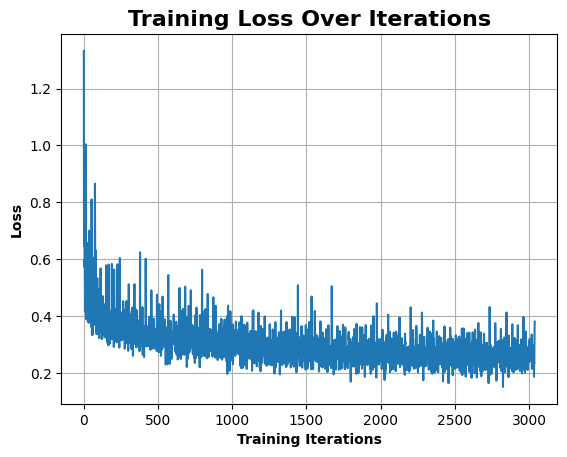

In [19]:
# Make a Plot for the Data
plt.plot(train_loss, label="Training Loss")

# Add Title & Axis Labels
plt.title("Training Loss Over Iterations", fontweight = "bold", fontsize="16")
plt.xlabel("Training Iterations", fontweight = "bold")
plt.ylabel("Loss", fontweight = "bold")

# Add Grid
plt.grid(True)

# Show Plot
plt.show()

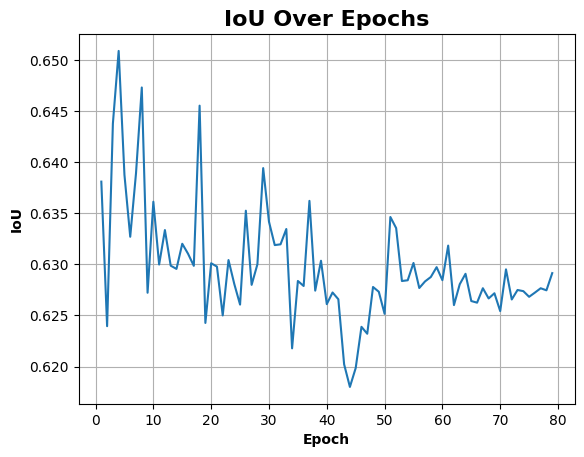

In [20]:
# Epochs from 1 to 80
epochs = list(range(1, 80))

# Plot IoU vs. Epoch
plt.plot(epochs, IoU_list, label="IoU")

# Add Title & Axis Labels
plt.title("IoU Over Epochs", fontweight = "bold", fontsize="16")
plt.xlabel("Epoch", fontweight = "bold")
plt.ylabel("IoU", fontweight = "bold")

# Add Grid
plt.grid(True)

# Show Plot
plt.show()

<br/>

## **Randomised Prediction Test Results from the Model:**

This function randomly selects a few predicted segmentation masks and their corresponding original images, then displays them side-by-side. It helps qualitatively assess the model’s performance by providing a clear comparison between the input images and the predicted outputs.

In [21]:
def show_random_predictions(temp_colour_folder, train_image_folder, num_images=3):
    """
    Picks a few random predicted segmentation mask images and their corresponding original images,
    then displays them side-by-side for visual comparison.

    Args:
        temp_color_folder (str): Path to folder containing predicted color masks.
        train_image_folder (str): Path to folder containing original training images.
        num_images (int): Number of random samples to display.
    """

    # List All Predicted Colour Mask Image Filenames
    pred_images = os.listdir(temp_colour_folder)

    # Randomly Select 'num_images' Filenames From the Predictions List
    selected_imgs = random.sample(pred_images, num_images)

    # Set Up Matplotlib Figure with Enough Height to Show All Selected Images Clearly
    plt.figure(figsize=(15, num_images * 5))

    # Loop Over the Selected Image Names & Plot Each Original & Predicted Pair
    for i, img_name in enumerate(selected_imgs):
        # Load Predicted Colour Mask Image (OpenCV Loads in BGR by Default)
        pred_img = cv2.imread(os.path.join(temp_colour_folder, img_name))

        # Convert Predicted Mask Image From BGR to RGB for Proper Colour Display in matplotlib
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

        # Load the Corresponding Original Training Image (also BGR)
        orig_img = cv2.imread(os.path.join(train_image_folder, img_name))

        # Convert Original Image from BGR to RGB for Display
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # Plot Original Image in Left Column
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(orig_img)
        plt.title(f'Original Image: {img_name}')
        plt.axis('off')

        # Plot Predicted Mask in Right Column
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(pred_img)
        plt.title(f'Predicted Mask: {img_name}')
        plt.axis('off')

    # Adjust Spacing So Titles & Images Don't Overlap
    plt.tight_layout()

    # Display the Plot Window
    plt.show()

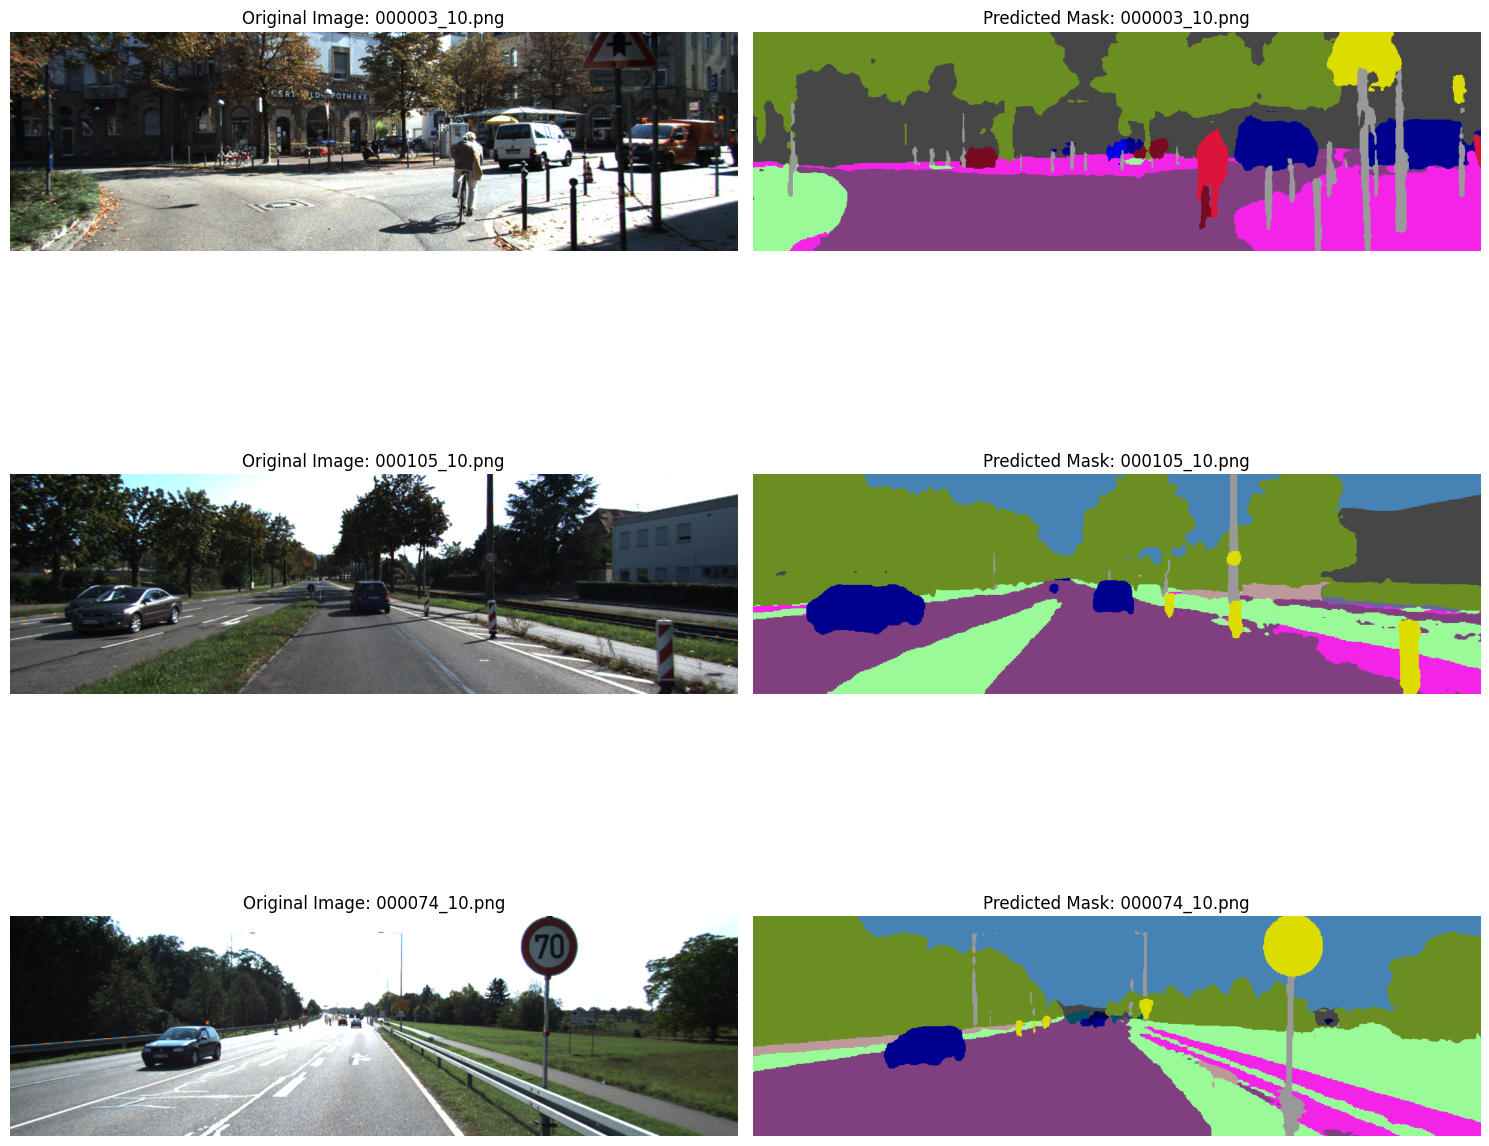

In [22]:
# Define Folder Paths for Predicted Masks & Original Images
temp_color_folder = '/content/TempFiles/color'
#  temp_color_folder = './TempFiles/color'
train_image_folder = '/content/drive/MyDrive/seg_data/testing/image'
# train_image_folder = './Data/seg_data/testing/image'

# Call the Function to Display 3 Random Prediction Results
show_random_predictions(temp_color_folder, train_image_folder, num_images=3)

<br/><br>

# **FLOPs**

This section calculates the total number of floating point operations (FLOPs) the model performs during a single forward pass, providing a measure of its computational cost. Using the fvcore library, we quantify the model’s complexity in GFLOPs, which helps compare efficiency across different architectures.

In deep learning, FLOPs *(Floating Point Operations)* quantify the total number of arithmetic operations, such as additions, multiplications, and divisions, that a model performs during a single forward pass *(i.e. when making a prediction)*. This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs *(Giga Floating Point Operations)*, where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

**DO NOT MODIFY THIS CODE!**

In [23]:
# We use Fvcore to Calculate the FLOPs
# !pip3 install fvcore

In [ ]:
from fvcore.nn import FlopCountAnalysis

# Modifying the Size (3, 375, 1242) is ***NOT*** Allowed
input = torch.randn(1, 3, 375, 1242)

# Get the Network & its FLOPs
model = smp.Segformer(encoder_name="mit_b2", encoder_weights=None, in_channels=3, classes=19).cpu()
model.eval()
input = input.cpu()
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

FLOPs: 50.50 GFLOPs
